In [1]:
import nannyml as nml

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
print(nml.__path__)

['/Users/carterblair/NannyMLdev/nannyml/nannyml']


In [3]:
np.random.seed(3)
n = 50_000
neg_size = 0.65
pos_size = 1 - neg_size
x1 = np.random.normal(loc=0, scale=1, size=int(n * neg_size))
x2 = np.random.normal(loc=2, scale=1, size=int(n * pos_size))
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])

# shuffle the data
shuffle = np.random.permutation(n)
x = x[shuffle]
y = y[shuffle]

# partition the data into 3 partitions named train, ref, and ana
train_size = 0.5
ref_size = 0.4
ana_size = 0.1

train_idx = int(n * train_size)
ref_idx = int(n * (train_size + ref_size))
ana_idx = int(n * (train_size + ref_size + ana_size))

x_train = x[:train_idx]
y_train = y[:train_idx]

x_ref = x[train_idx:ref_idx]
y_ref = y[train_idx:ref_idx]

x_ana = x[ref_idx:ana_idx]
y_ana = y[ref_idx:ana_idx]

# fit the model
clf = LogisticRegression(random_state=0).fit(x_train.reshape(-1, 1), y_train)

# get the predictions
y_pred_ref = clf.predict(x_ref.reshape(-1, 1))
y_pred_proba_ref = clf.predict_proba(x_ref.reshape(-1, 1))[:, 1]

y_pred_ana = clf.predict(x_ana.reshape(-1, 1))
y_pred_proba_ana = clf.predict_proba(x_ana.reshape(-1, 1))[:, 1]

In [4]:
#make a reference dataframe
ref = pd.DataFrame({
    'x': x_ref,
    'y_true': y_ref,
    'y_pred': y_pred_ref,
    'y_pred_proba': y_pred_proba_ref,
})

#make an analysis dataframe
ana = pd.DataFrame({
    'x': x_ana,
    'y_true': y_ana,
    'y_pred': y_pred_ana,
    'y_pred_proba': y_pred_proba_ana,
})

# Normalize = None

## Calculate real performance

In [5]:
chunker = nml.SizeBasedChunker(chunk_size=500)
ana_chunks = chunker.split(ana)

tp_rates = []
tn_rates = []
fp_rates = []
fn_rates = []

for chunk in ana_chunks:
    data = chunk.data
    #find the true positive rate
    num_tps = len(data[(data['y_true'] == 1) & (data['y_pred'] == 1)])
    num_tns = len(data[(data['y_true'] == 0) & (data['y_pred'] == 0)])
    num_fps = len(data[(data['y_true'] == 0) & (data['y_pred'] == 1)])
    num_fns = len(data[(data['y_true'] == 1) & (data['y_pred'] == 0)])

    tp_rates.append(num_tps)
    tn_rates.append(num_tns)
    fp_rates.append(num_fps)
    fn_rates.append(num_fns)

## Estimate Performance

In [6]:
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='y_true',
    metrics=[ 'confusion_matrix'],
    chunk_size=500,
    problem_type='classification_binary',
    normalize_confusion_matrix=None,
)

estimator.fit(ref)

est_perf = estimator.estimate(ana)

est_perf_df = est_perf.to_df()
est_perf_df = est_perf_df[est_perf_df['chunk']['period'] == 'analysis']

est_tp_per_chunk = est_perf_df['true_positive']['value'].values
est_tp_se_per_chunk = est_perf_df['true_positive']['sampling_error'].values

est_tn_per_chunk = est_perf_df['true_negative']['value'].values
est_tn_se_per_chunk = est_perf_df['true_negative']['sampling_error'].values

est_fp_per_chunk = est_perf_df['false_positive']['value'].values
est_fp_se_per_chunk = est_perf_df['false_positive']['sampling_error'].values

est_fn_per_chunk = est_perf_df['false_negative']['value'].values
est_fn_se_per_chunk = est_perf_df['false_negative']['sampling_error'].values

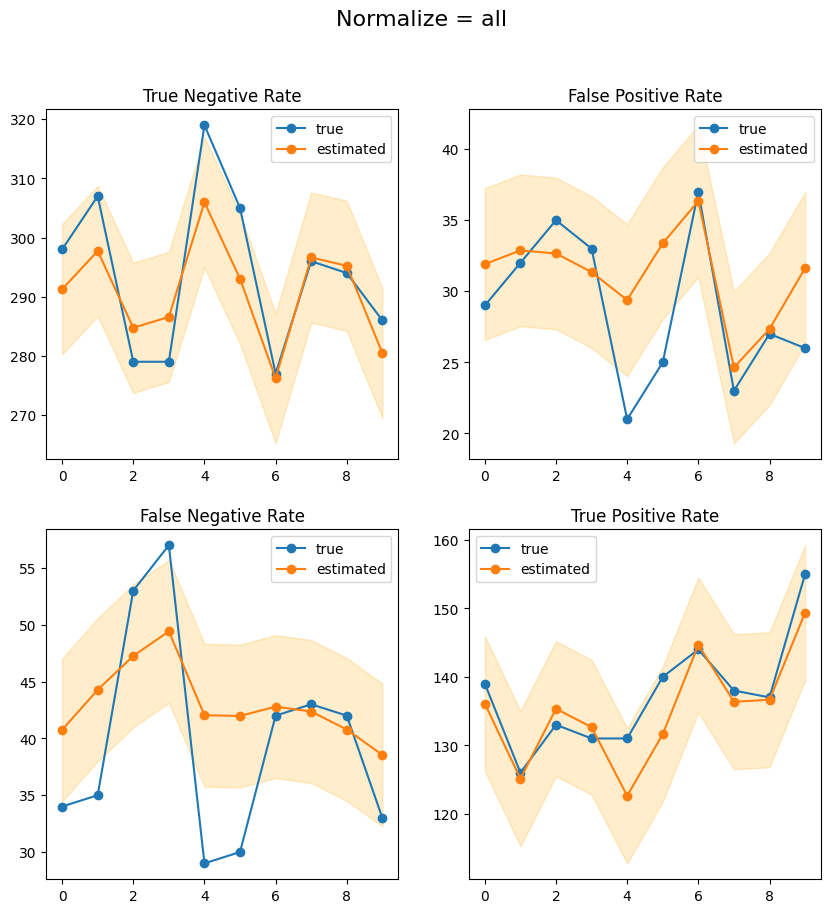

In [7]:
# plot the results
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(tn_rates, label='true', marker = 'o')
ax[0, 0].plot(est_tn_per_chunk, label='estimated', marker = 'o')
ax[0,0].fill_between(range(len(est_tn_per_chunk)), est_tn_per_chunk - est_tn_se_per_chunk, est_tn_per_chunk + est_tn_se_per_chunk, alpha=0.2, color = "orange")
ax[0, 0].legend()
ax[0,0].set_title('True Negative Rate')

ax[0, 1].plot(fp_rates, label='true', marker = 'o')
ax[0, 1].plot(est_fp_per_chunk, label='estimated', marker = 'o')
ax[0, 1].fill_between(range(len(est_fp_per_chunk)), est_fp_per_chunk - est_fp_se_per_chunk, est_fp_per_chunk + est_fp_se_per_chunk, alpha=0.2, color = "orange")
ax[0, 1].legend()
ax[0,1].set_title('False Positive Rate')

ax[1, 0].plot(fn_rates, label='true', marker = 'o')
ax[1, 0].plot(est_fn_per_chunk, label='estimated', marker = 'o')
ax[1, 0].fill_between(range(len(est_fn_per_chunk)), est_fn_per_chunk - est_fn_se_per_chunk, est_fn_per_chunk + est_fn_se_per_chunk, alpha=0.2, color = "orange")
ax[1, 0].legend()
ax[1,0].set_title('False Negative Rate')

ax[1, 1].plot(tp_rates, label='true', marker = 'o')
ax[1, 1].plot(est_tp_per_chunk, label='estimated', marker = 'o')
ax[1, 1].fill_between(range(len(est_tp_per_chunk)), est_tp_per_chunk - est_tp_se_per_chunk, est_tp_per_chunk + est_tp_se_per_chunk, alpha=0.2, color = "orange")
ax[1, 1].legend()
ax[1,1].set_title('True Positive Rate')

#make figure level title
fig.suptitle('Normalize = all', fontsize=16)

plt.show()
    

# Normalize = "all"

In [8]:
chunker = nml.SizeBasedChunker(chunk_size=500)
ana_chunks = chunker.split(ana)

tp_rates = []
tn_rates = []
fp_rates = []
fn_rates = []

for chunk in ana_chunks:
    data = chunk.data
    #find the true positive rate
    num_tps = len(data[(data['y_true'] == 1) & (data['y_pred'] == 1)])
    num_tns = len(data[(data['y_true'] == 0) & (data['y_pred'] == 0)])
    num_fps = len(data[(data['y_true'] == 0) & (data['y_pred'] == 1)])
    num_fns = len(data[(data['y_true'] == 1) & (data['y_pred'] == 0)])

    tp_rates.append(num_tps/len(data))
    tn_rates.append(num_tns/len(data))
    fp_rates.append(num_fps/len(data))
    fn_rates.append(num_fns/len(data))

In [9]:
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='y_true',
    metrics=[ 'confusion_matrix'],
    chunk_size=500,
    problem_type='classification_binary',
    normalize_confusion_matrix="all",
)

estimator.fit(ref)

est_perf = estimator.estimate(ana)

In [10]:
est_perf_df = est_perf.to_df()
est_perf_df = est_perf_df[est_perf_df['chunk']['period'] == 'analysis']

est_tp_per_chunk = est_perf_df['true_positive']['value'].values
est_tp_se_per_chunk = est_perf_df['true_positive']['sampling_error'].values

est_tn_per_chunk = est_perf_df['true_negative']['value'].values
est_tn_se_per_chunk = est_perf_df['true_negative']['sampling_error'].values

est_fp_per_chunk = est_perf_df['false_positive']['value'].values
est_fp_se_per_chunk = est_perf_df['false_positive']['sampling_error'].values

est_fn_per_chunk = est_perf_df['false_negative']['value'].values
est_fn_se_per_chunk = est_perf_df['false_negative']['sampling_error'].values

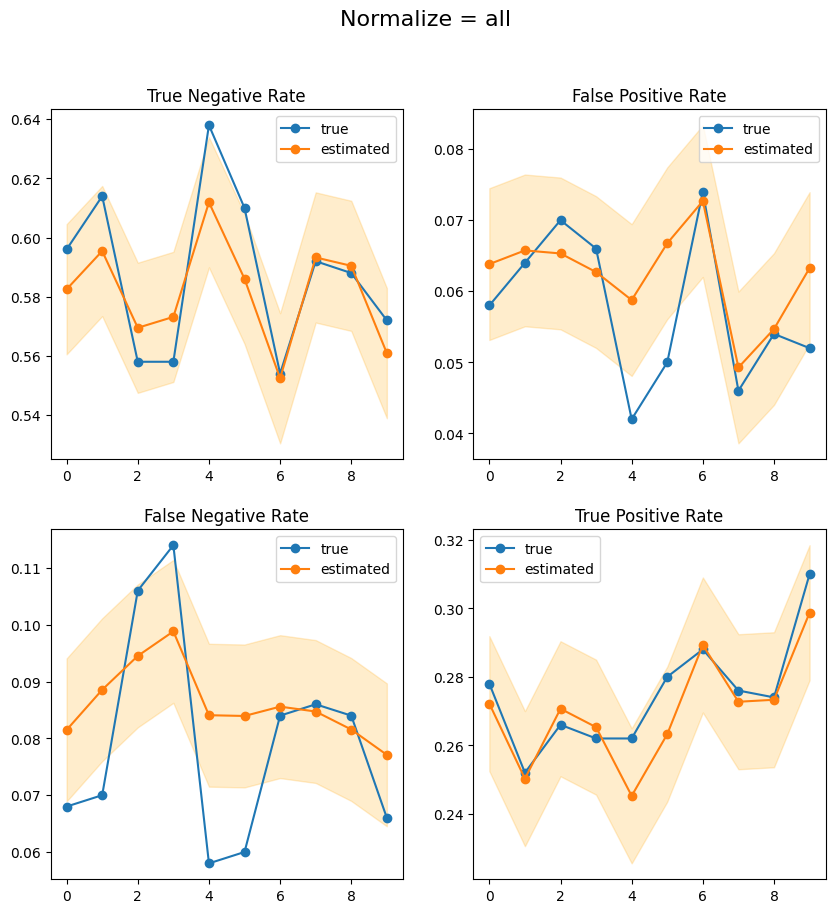

In [11]:
# plot the results
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(tn_rates, label='true', marker = 'o')
ax[0, 0].plot(est_tn_per_chunk, label='estimated', marker = 'o')
ax[0,0].fill_between(range(len(est_tn_per_chunk)), est_tn_per_chunk - est_tn_se_per_chunk, est_tn_per_chunk + est_tn_se_per_chunk, alpha=0.2, color = "orange")
ax[0, 0].legend()
ax[0,0].set_title('True Negative Rate')

ax[0, 1].plot(fp_rates, label='true', marker = 'o')
ax[0, 1].plot(est_fp_per_chunk, label='estimated', marker = 'o')
ax[0, 1].fill_between(range(len(est_fp_per_chunk)), est_fp_per_chunk - est_fp_se_per_chunk, est_fp_per_chunk + est_fp_se_per_chunk, alpha=0.2, color = "orange")
ax[0, 1].legend()
ax[0,1].set_title('False Positive Rate')

ax[1, 0].plot(fn_rates, label='true', marker = 'o')
ax[1, 0].plot(est_fn_per_chunk, label='estimated', marker = 'o')
ax[1, 0].fill_between(range(len(est_fn_per_chunk)), est_fn_per_chunk - est_fn_se_per_chunk, est_fn_per_chunk + est_fn_se_per_chunk, alpha=0.2, color = "orange")
ax[1, 0].legend()
ax[1,0].set_title('False Negative Rate')

ax[1, 1].plot(tp_rates, label='true', marker = 'o')
ax[1, 1].plot(est_tp_per_chunk, label='estimated', marker = 'o')
ax[1, 1].fill_between(range(len(est_tp_per_chunk)), est_tp_per_chunk - est_tp_se_per_chunk, est_tp_per_chunk + est_tp_se_per_chunk, alpha=0.2, color = "orange")
ax[1, 1].legend()
ax[1,1].set_title('True Positive Rate')

#make figure level title
fig.suptitle('Normalize = all', fontsize=16)

plt.show()

# Normalize = "true"

In [12]:
chunker = nml.SizeBasedChunker(chunk_size=500)
ana_chunks = chunker.split(ana)

tp_rates = []
tn_rates = []
fp_rates = []
fn_rates = []

for chunk in ana_chunks:
    data = chunk.data
    #find the true positive rate
    num_tps = len(data[(data['y_true'] == 1) & (data['y_pred'] == 1)])
    num_tns = len(data[(data['y_true'] == 0) & (data['y_pred'] == 0)])
    num_fps = len(data[(data['y_true'] == 0) & (data['y_pred'] == 1)])
    num_fns = len(data[(data['y_true'] == 1) & (data['y_pred'] == 0)])

    tp_rates.append(num_tps/(num_tps + num_fns))
    tn_rates.append(num_tns/(num_tns + num_fps))
    fp_rates.append(num_fps/(num_tns + num_fps))
    fn_rates.append(num_fns/(num_tps + num_fns))

In [13]:
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='y_true',
    metrics=[ 'confusion_matrix'],
    chunk_size=500,
    problem_type='classification_binary',
    normalize_confusion_matrix="true",
)

estimator.fit(ref)

est_perf = estimator.estimate(ana)

In [14]:
est_perf_df = est_perf.to_df()
est_perf_df = est_perf_df[est_perf_df['chunk']['period'] == 'analysis']

est_tp_per_chunk = est_perf_df['true_positive']['value'].values
est_tp_se_per_chunk = est_perf_df['true_positive']['sampling_error'].values

est_tn_per_chunk = est_perf_df['true_negative']['value'].values
est_tn_se_per_chunk = est_perf_df['true_negative']['sampling_error'].values

est_fp_per_chunk = est_perf_df['false_positive']['value'].values
est_fp_se_per_chunk = est_perf_df['false_positive']['sampling_error'].values

est_fn_per_chunk = est_perf_df['false_negative']['value'].values
est_fn_se_per_chunk = est_perf_df['false_negative']['sampling_error'].values

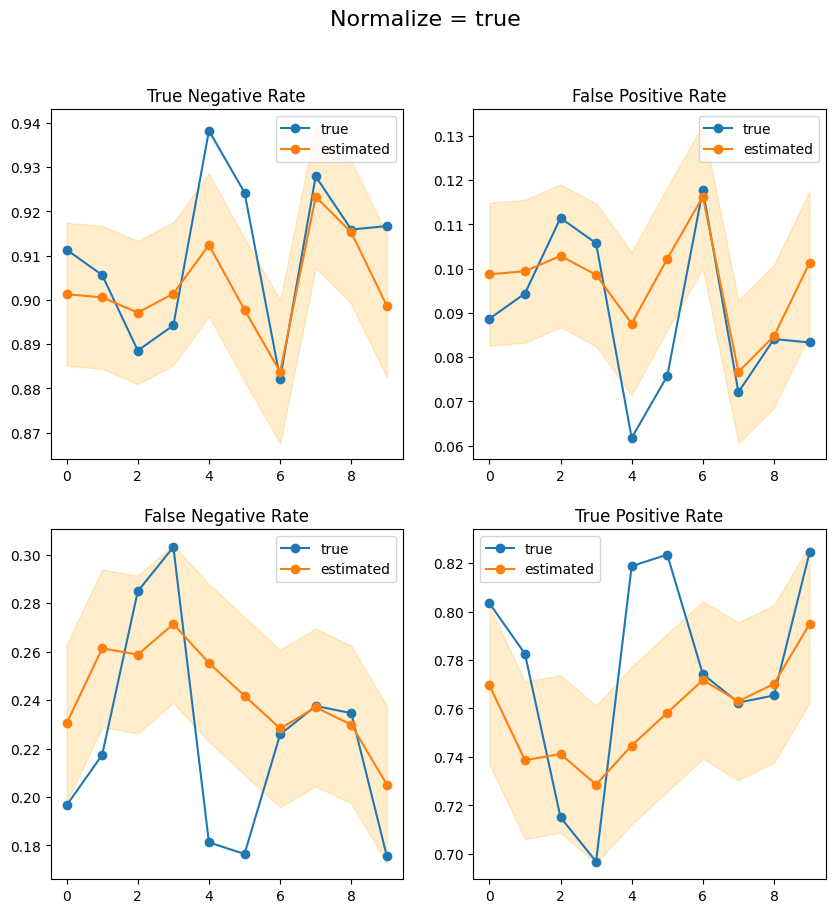

In [15]:
# plot the results
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(tn_rates, label='true', marker = 'o')
ax[0, 0].plot(est_tn_per_chunk, label='estimated', marker = 'o')
ax[0,0].fill_between(range(len(est_tn_per_chunk)), est_tn_per_chunk - est_tn_se_per_chunk, est_tn_per_chunk + est_tn_se_per_chunk, alpha=0.2, color = "orange")
ax[0, 0].legend()
ax[0,0].set_title('True Negative Rate')

ax[0, 1].plot(fp_rates, label='true', marker = 'o')
ax[0, 1].plot(est_fp_per_chunk, label='estimated', marker = 'o')
ax[0, 1].fill_between(range(len(est_fp_per_chunk)), est_fp_per_chunk - est_fp_se_per_chunk, est_fp_per_chunk + est_fp_se_per_chunk, alpha=0.2, color = "orange")
ax[0, 1].legend()
ax[0,1].set_title('False Positive Rate')

ax[1, 0].plot(fn_rates, label='true', marker = 'o')
ax[1, 0].plot(est_fn_per_chunk, label='estimated', marker = 'o')
ax[1, 0].fill_between(range(len(est_fn_per_chunk)), est_fn_per_chunk - est_fn_se_per_chunk, est_fn_per_chunk + est_fn_se_per_chunk, alpha=0.2, color = "orange")
ax[1, 0].legend()
ax[1,0].set_title('False Negative Rate')

ax[1, 1].plot(tp_rates, label='true', marker = 'o')
ax[1, 1].plot(est_tp_per_chunk, label='estimated', marker = 'o')
ax[1, 1].fill_between(range(len(est_tp_per_chunk)), est_tp_per_chunk - est_tp_se_per_chunk, est_tp_per_chunk + est_tp_se_per_chunk, alpha=0.2, color = "orange")
ax[1, 1].legend()
ax[1,1].set_title('True Positive Rate')

#make figure level title
fig.suptitle('Normalize = true', fontsize=16)

plt.show()

# Normalize = "pred"

In [16]:
chunker = nml.SizeBasedChunker(chunk_size=500)
ana_chunks = chunker.split(ana)

tp_rates = []
tn_rates = []
fp_rates = []
fn_rates = []

for chunk in ana_chunks:
    data = chunk.data
    #find the true positive rate
    num_tps = len(data[(data['y_true'] == 1) & (data['y_pred'] == 1)])
    num_tns = len(data[(data['y_true'] == 0) & (data['y_pred'] == 0)])
    num_fps = len(data[(data['y_true'] == 0) & (data['y_pred'] == 1)])
    num_fns = len(data[(data['y_true'] == 1) & (data['y_pred'] == 0)])

    tp_rates.append(num_tps/(num_tps + num_fps))
    tn_rates.append(num_tns/(num_tns + num_fns))
    fp_rates.append(num_fps/(num_tps + num_fps))
    fn_rates.append(num_fns/(num_tns + num_fns))

In [17]:
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='y_true',
    metrics=[ 'confusion_matrix'],
    chunk_size=500,
    problem_type='classification_binary',
    normalize_confusion_matrix="pred",
)

estimator.fit(ref)

est_perf = estimator.estimate(ana)

In [18]:
est_perf_df = est_perf.to_df()
est_perf_df = est_perf_df[est_perf_df['chunk']['period'] == 'analysis']

est_tp_per_chunk = est_perf_df['true_positive']['value'].values
est_tp_se_per_chunk = est_perf_df['true_positive']['sampling_error'].values

est_tn_per_chunk = est_perf_df['true_negative']['value'].values
est_tn_se_per_chunk = est_perf_df['true_negative']['sampling_error'].values

est_fp_per_chunk = est_perf_df['false_positive']['value'].values
est_fp_se_per_chunk = est_perf_df['false_positive']['sampling_error'].values

est_fn_per_chunk = est_perf_df['false_negative']['value'].values
est_fn_se_per_chunk = est_perf_df['false_negative']['sampling_error'].values

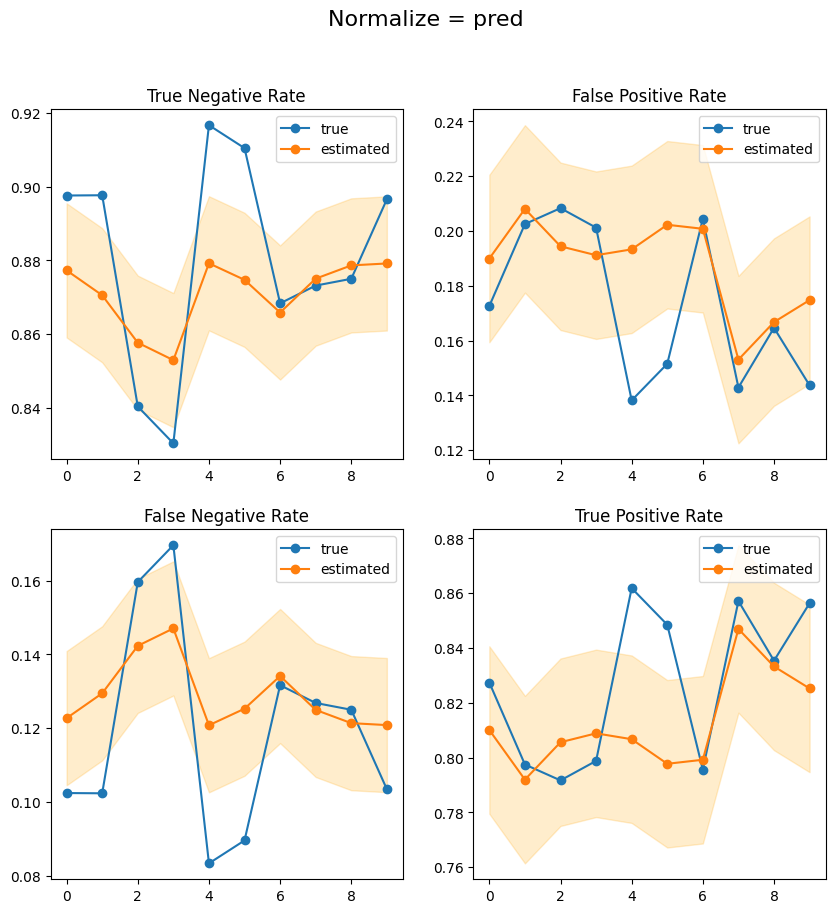

In [19]:
# plot the results
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(tn_rates, label='true', marker = 'o')
ax[0, 0].plot(est_tn_per_chunk, label='estimated', marker = 'o')
ax[0,0].fill_between(range(len(est_tn_per_chunk)), est_tn_per_chunk - est_tn_se_per_chunk, est_tn_per_chunk + est_tn_se_per_chunk, alpha=0.2, color = "orange")
ax[0, 0].legend()
ax[0,0].set_title('True Negative Rate')

ax[0, 1].plot(fp_rates, label='true', marker = 'o')
ax[0, 1].plot(est_fp_per_chunk, label='estimated', marker = 'o')
ax[0, 1].fill_between(range(len(est_fp_per_chunk)), est_fp_per_chunk - est_fp_se_per_chunk, est_fp_per_chunk + est_fp_se_per_chunk, alpha=0.2, color = "orange")
ax[0, 1].legend()
ax[0,1].set_title('False Positive Rate')

ax[1, 0].plot(fn_rates, label='true', marker = 'o')
ax[1, 0].plot(est_fn_per_chunk, label='estimated', marker = 'o')
ax[1, 0].fill_between(range(len(est_fn_per_chunk)), est_fn_per_chunk - est_fn_se_per_chunk, est_fn_per_chunk + est_fn_se_per_chunk, alpha=0.2, color = "orange")
ax[1, 0].legend()
ax[1,0].set_title('False Negative Rate')

ax[1, 1].plot(tp_rates, label='true', marker = 'o')
ax[1, 1].plot(est_tp_per_chunk, label='estimated', marker = 'o')
ax[1, 1].fill_between(range(len(est_tp_per_chunk)), est_tp_per_chunk - est_tp_se_per_chunk, est_tp_per_chunk + est_tp_se_per_chunk, alpha=0.2, color = "orange")
ax[1, 1].legend()
ax[1,1].set_title('True Positive Rate')

#make figure level title
fig.suptitle('Normalize = pred', fontsize=16)

plt.show()

# Testing exception

In [20]:
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='y_true',
    metrics=[ 'confusion_matrix'],
    chunk_size=500,
    problem_type='classification_binary',
    normalize_confusion_matrix="foo",
)

estimator.fit(ref)

est_perf = estimator.estimate(ana)

InvalidArgumentsException: 'normalize_confusion_matrix' given was 'foo'. Binary use cases require 'normalize_confusion_matrix' to be one of [None, 'all', 'pred', 'true'].